In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [3]:
train = pd.read_csv('./Genre Classification Dataset/train_data.txt', sep=":::", names=["TITLE", "GENRE", "DESCRIPTION"], engine="python")
test = pd.read_csv('./Genre Classification Dataset/test_data.txt', sep=":::", names=["TITLE", "GENRE", "DESCRIPTION"], engine="python")

In [4]:
print(train.shape)
print(test.shape)

(54214, 3)
(54200, 3)


In [5]:
print(train.info())
train.head

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54214 non-null  object
 1   GENRE        54214 non-null  object
 2   DESCRIPTION  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None


<bound method NDFrame.head of                                               TITLE          GENRE  \
1                     Oscar et la dame rose (2009)          drama    
2                                     Cupid (1997)       thriller    
3                 Young, Wild and Wonderful (1980)          adult    
4                            The Secret Sin (1915)          drama    
5                           The Unrecovered (2007)          drama    
...                                             ...            ...   
54210                              "Bonino" (1953)         comedy    
54211                  Dead Girls Don't Cry (????)         horror    
54212    Ronald Goedemondt: Ze bestaan echt (2008)    documentary    
54213                     Make Your Own Bed (1944)         comedy    
54214   Nature's Fury: Storm of the Century (2006)        history    

                                             DESCRIPTION  
1       Listening in to a conversation between his do...  
2       A b

In [6]:
print(test.info())
print(test.head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54200 non-null  int64 
 1   GENRE        54200 non-null  object
 2   DESCRIPTION  54200 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None
<bound method NDFrame.head of        TITLE                             GENRE  \
0          1             Edgar's Lunch (1998)    
1          2         La guerra de papá (1977)    
2          3      Off the Beaten Track (2010)    
3          4           Meu Amigo Hindu (2015)    
4          5                Er nu zhai (1955)    
...      ...                               ...   
54195  54196   "Tales of Light & Dark" (2013)    
54196  54197      Der letzte Mohikaner (1965)    
54197  54198              Oliver Twink (2007)    
54198  54199                Slipstream (1973)    
54199  54200        Curitiba Zero Grau (2010)    

 

In [7]:
train['GENRE'].value_counts() # Class imbalance is clearly visible

GENRE
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64

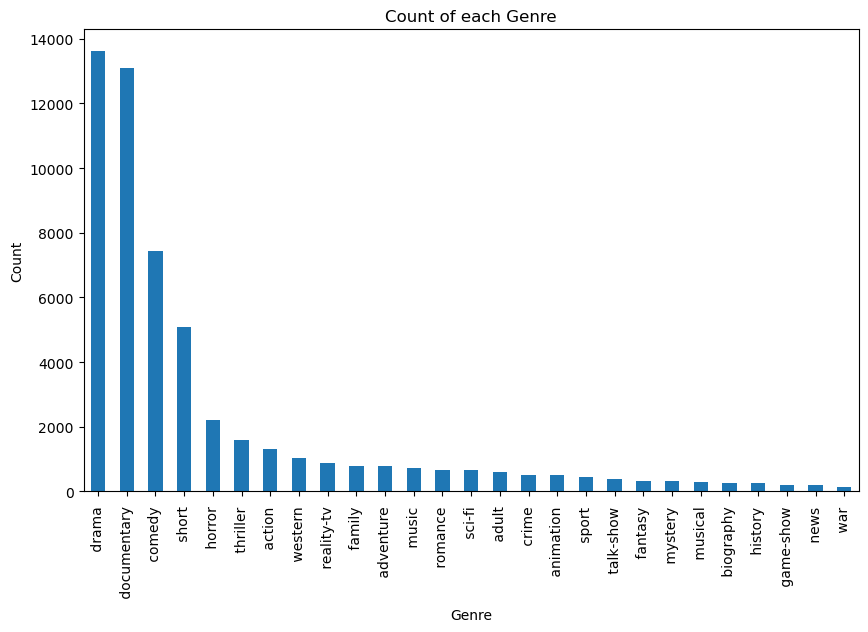

In [8]:
plt.figure(figsize=(10, 6))
train['GENRE'].value_counts().plot(kind='bar')
plt.title('Count of each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

In [9]:
print(train.dtypes)
print(test.dtypes)

TITLE          object
GENRE          object
DESCRIPTION    object
dtype: object
TITLE           int64
GENRE          object
DESCRIPTION    object
dtype: object


In [10]:
def cleaning(text):
    # Define stopwords set
    stop_words = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"}
    
    # Convert text to lowercase
    text = text.lower()
    # Remove mentions
    text = ' '.join(word for word in text.split() if not word.startswith('@'))
    # Remove URLs
    text = ' '.join(word for word in text.split() if not word.startswith('http'))
    # Remove .pic occurrences
    text = text.replace('.pic', '')
    # Replace non-alphabetic characters with a space
    text = ''.join(char if char.isalpha() else ' ' for char in text)
    # Remove punctuation
    text = ''.join(char for char in text if char not in '!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    # Remove stop words and words with length <= 2
    text = ' '.join(word for word in text.split() if word not in stop_words and len(word) > 2)
    # Replace multiple spaces with a single space
    text = ' '.join(text.split())
    return text

train["clean_text"] = train["DESCRIPTION"].apply(cleaning)
test["clean_text"] = test["DESCRIPTION"].apply(cleaning)

In [11]:
train['GENRE'].value_counts()

GENRE
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64

In [12]:
train.head()

,TITLE,GENRE,DESCRIPTION,clean_text
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film title refers recovered bodies ground zero...


In [13]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train["clean_text"])
X_test = vectorizer.transform(test["clean_text"])

In [14]:
y_train = train["GENRE"]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [15]:
print(X_train)

  (0, 25482)	0.1813127502011378
  (0, 39688)	0.1813127502011378
  (0, 16523)	0.17273856615727534
  (0, 93428)	0.16709089550760972
  (0, 80516)	0.15033063610762804
  (0, 107307)	0.14106419094660144
  (0, 78890)	0.15123815187101886
  (0, 26373)	0.13960370908056108
  (0, 82055)	0.12558287418988073
  (0, 111389)	0.14443243912181544
  (0, 94386)	0.6013225444305121
  (0, 25895)	0.15545645271715197
  (0, 16084)	0.12314053624884895
  (0, 21994)	0.12479284823619495
  (0, 87531)	0.13477497903930674
  (0, 6694)	0.14056311036569216
  (0, 10323)	0.10714271865021956
  (0, 75210)	0.1595043464862626
  (0, 34417)	0.11177042888862622
  (0, 98011)	0.12040392378189584
  (0, 13105)	0.10648180835564203
  (0, 45125)	0.10769084745120813
  (0, 32042)	0.1143578407916965
  (0, 60685)	0.12070366304917009
  (0, 63948)	0.12641192926254338
  :	:
  (43369, 84091)	0.12045790357886031
  (43369, 93322)	0.11903009309988398
  (43369, 76207)	0.10111818824999513
  (43369, 56776)	0.08759571412514408
  (43369, 20715)	0.095114

In [16]:
y_train

19254           drama 
12262           drama 
37144     documentary 
21966     documentary 
7034           comedy 
             ...      
11285          comedy 
44733           drama 
38159           drama 
861             drama 
15796     documentary 
Name: GENRE, Length: 43371, dtype: object

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [16]:
# models = [
#     {
#         "name": "SVM",
#         "estimator": SVC(),
#         "param_grid": {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'auto'], 'kernel': ['linear', 'rbf']},
#     },
#     {
#         "name": "Naive Bayes",
#         "estimator": MultinomialNB(),
#         "param_grid": {'alpha': [0.1, 1, 10]},
#     },
#     {
#         "name": "Decision Tree",
#         "estimator": DecisionTreeClassifier(),
#         "param_grid": {'max_depth': [None, 10, 50], 'min_samples_split': [2, 5, 10]},
#     },
#     {
#         "name": "Random Forest",
#         "estimator": RandomForestClassifier(),
#         "param_grid": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 50], 'min_samples_split': [2, 5, 10]},
#     },
#     {
#         "name": "AdaBoost",
#         "estimator": AdaBoostClassifier(),
#         "param_grid": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
#     },
#     {
#         "name": "Voting Classifier",
#         "estimator": VotingClassifier(estimators=[
#             ('svm', SVC()), ('nb', MultinomialNB()), ('dt', DecisionTreeClassifier()), ('rf', RandomForestClassifier()), ('ada', AdaBoostClassifier())
#         ]),
#         "param_grid": {'voting': ['hard', 'soft']},
#     },
#     {
#         "name": "Bagging Classifier",
#         "estimator": BaggingClassifier(),
#         "param_grid": {'n_estimators': [10, 50, 100]},
#     },
#     {
#         "name": "XGBoost",
#         "estimator": XGBClassifier(),
#         "param_grid": {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 1]},
#     }
# ]

# # I tried Grid search for each model takes a lot of time becuz size of dataset is big so we just fit it instead
# for model in models:
#     print("Training", model["name"])
#     grid_search = GridSearchCV(model["estimator"], model["param_grid"], cv=5, scoring='accuracy', n_jobs=-1)
#     grid_search.fit(X_train, y_train)
    
#     print("Best Parameters:", grid_search.best_params_)
#     best_model = grid_search.best_estimator_
#     y_pred = best_model.predict(X_val)
#     acc = accuracy_score(y_pred, y_val)
#     print("Validation Accuracy:", acc)

#     # Evaluate on test data
#     test_acc = best_model.score(X_test, test["GENRE"])
#     print("Test Accuracy:", test_acc)
#     print("=" * 50)

In [21]:
# Logistic Regression (58.03744351194319)
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predict on validation set
y_pred_val = lr.predict(X_val)
val_acc = accuracy_score(y_pred_val, y_val)
print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.5803744351194319


c:\Users\anura\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# Multinomial NB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Predict on validation set
y_pred_val = mnb.predict(X_val)
val_acc = accuracy_score(y_pred_val, y_val)
print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.4462787051553998


In [18]:
# Decision Tree
dt_params = {
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 1
}

dt = DecisionTreeClassifier(**dt_params)

dt.fit(X_train, y_train)

# Predict on validation set
y_pred_val = dt.predict(X_val)
val_acc = accuracy_score(y_pred_val, y_val)
print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.38623997048787234


In [19]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=1)
rf.fit(X_train, y_train)

# Predict on validation set
y_pred_val = rf.predict(X_val)
val_acc = accuracy_score(y_pred_val, y_val)
print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.4274647237849304


In [22]:
prediction = lr.predict(X_test)
prediction

array([8, 8, 7, ..., 8, 5, 7])

In [24]:
pd.DataFrame(prediction).to_csv('./Prediction/predictions.csv', index = False)